# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect to Github repository and import code

In [2]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!git clone --branch 8-bit-Categorical --single-branch https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 217 (delta 14), reused 27 (delta 8), pack-reused 179 (from 1)
Receiving objects: 100% (217/217), 181.34 MiB | 42.85 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Updating files: 100% (8/8), done.


In [3]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin 8-bit-Categorical

# refrsh the imports
from importlib import reload
import VQ.model
reload(VQ.model)

from VQ.model import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS

/content/VQ-VAE-Tranformer-Image-Gen
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            8-bit-Categorical -> FETCH_HEAD
Already up to date.


### Load CelebA dataset

Dataset URL: https://www.kaggle.com/datasets/zuozhaorui/celeba
License(s): unknown
 95% 2.50G/2.64G [00:08<00:04, 30.1MB/s]
100% 2.64G/2.64G [00:08<00:00, 349MB/s] 


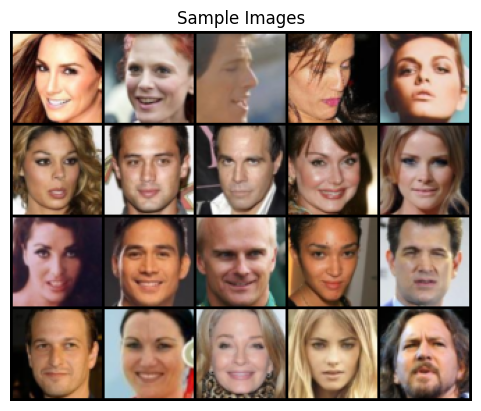

In [4]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

# load dataset using ImageFolder dataset
class CelebATransform:
    '''
    Crops around the face and resizes to IMG_HxIMG_W
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        return img

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.base = torchvision.datasets.ImageFolder(root=root, transform=CelebATransform())

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base.__getitem__(idx)
        target = torch.from_numpy(np.array(img)).permute(2, 0, 1).long()
        input = target.float() / 255.0
        return input, target

celeba = CelebADataset(root='./data/celeba')

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x)
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Train model

Checkpoint loaded. Resuming from training step 6000.
05:16:35 Begin Training
05:17:08 TRAINING Step [6100/24996]; Loss: 5.0376; Commitment: 0.9828; Usage (min/med/max/dead): 0.00, 1.14, 3.36, 31%
05:17:40 TRAINING Step [6200/24996]; Loss: 5.0317; Commitment: 0.9785; Usage (min/med/max/dead): 0.00, 1.15, 3.41, 31%
05:18:11 TRAINING Step [6300/24996]; Loss: 5.0324; Commitment: 0.9776; Usage (min/med/max/dead): 0.00, 1.16, 3.40, 31%
05:18:43 TRAINING Step [6400/24996]; Loss: 5.0333; Commitment: 0.9819; Usage (min/med/max/dead): 0.00, 1.16, 3.38, 30%
05:19:14 TRAINING Step [6500/24996]; Loss: 5.0423; Commitment: 0.9911; Usage (min/med/max/dead): 0.00, 1.16, 3.28, 30%
05:19:46 TRAINING Step [6600/24996]; Loss: 5.0441; Commitment: 0.9922; Usage (min/med/max/dead): 0.00, 1.15, 3.33, 30%
05:20:17 TRAINING Step [6700/24996]; Loss: 5.0437; Commitment: 0.9984; Usage (min/med/max/dead): 0.00, 1.15, 3.34, 30%
05:20:49 TRAINING Step [6800/24996]; Loss: 5.0492; Commitment: 0.9984; Usage (min/med/max/

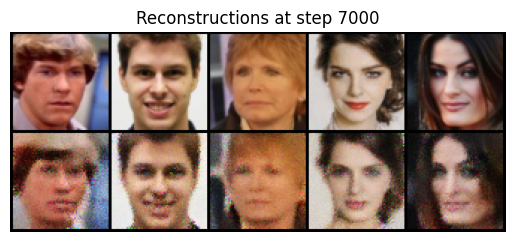

05:22:25 TRAINING Step [7100/24996]; Loss: 5.0517; Commitment: 1.0060; Usage (min/med/max/dead): 0.00, 1.16, 3.26, 30%
05:22:56 TRAINING Step [7200/24996]; Loss: 5.0505; Commitment: 1.0054; Usage (min/med/max/dead): 0.00, 1.17, 3.29, 30%
05:23:28 TRAINING Step [7300/24996]; Loss: 5.0573; Commitment: 1.0167; Usage (min/med/max/dead): 0.00, 1.18, 3.22, 30%
05:24:00 TRAINING Step [7400/24996]; Loss: 5.0588; Commitment: 1.0209; Usage (min/med/max/dead): 0.00, 1.18, 3.19, 30%
05:24:31 TRAINING Step [7500/24996]; Loss: 5.0619; Commitment: 1.0223; Usage (min/med/max/dead): 0.00, 1.18, 3.14, 30%
Checkpoint saved at step 7583 to /content/drive/MyDrive/vq_models/checkpoint.pt


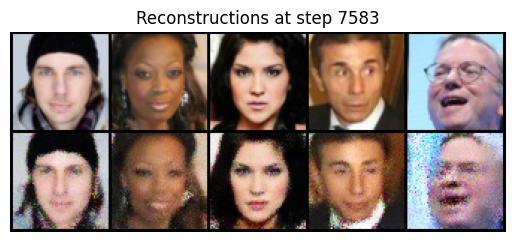

05:25:04 TRAINING Step [7600/24996]; Loss: 5.0608; Commitment: 1.0241; Usage (min/med/max/dead): 0.00, 1.18, 3.34, 30%
05:25:36 TRAINING Step [7700/24996]; Loss: 5.0589; Commitment: 1.0212; Usage (min/med/max/dead): 0.00, 1.20, 3.26, 30%
05:26:07 TRAINING Step [7800/24996]; Loss: 5.0600; Commitment: 1.0266; Usage (min/med/max/dead): 0.00, 1.21, 3.27, 30%
05:26:39 TRAINING Step [7900/24996]; Loss: 5.0604; Commitment: 1.0210; Usage (min/med/max/dead): 0.00, 1.21, 3.24, 30%
05:27:10 TRAINING Step [8000/24996]; Loss: 5.0539; Commitment: 1.0217; Usage (min/med/max/dead): 0.00, 1.21, 3.30, 30%
Checkpoint saved at step 8000 to /content/drive/MyDrive/vq_models/checkpoint.pt


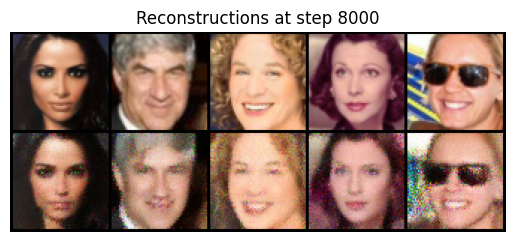

05:27:43 TRAINING Step [8100/24996]; Loss: 5.0595; Commitment: 1.0276; Usage (min/med/max/dead): 0.00, 1.20, 3.12, 30%
05:28:14 TRAINING Step [8200/24996]; Loss: 5.0680; Commitment: 1.0342; Usage (min/med/max/dead): 0.00, 1.21, 3.14, 30%
05:28:46 TRAINING Step [8300/24996]; Loss: 5.0672; Commitment: 1.0352; Usage (min/med/max/dead): 0.00, 1.21, 3.05, 30%
05:29:18 TRAINING Step [8400/24996]; Loss: 5.0723; Commitment: 1.0375; Usage (min/med/max/dead): 0.00, 1.22, 3.04, 30%
05:29:49 TRAINING Step [8500/24996]; Loss: 5.0700; Commitment: 1.0375; Usage (min/med/max/dead): 0.00, 1.22, 2.99, 30%
05:30:21 TRAINING Step [8600/24996]; Loss: 5.0737; Commitment: 1.0350; Usage (min/med/max/dead): 0.00, 1.21, 3.03, 30%
05:30:52 TRAINING Step [8700/24996]; Loss: 5.0651; Commitment: 1.0368; Usage (min/med/max/dead): 0.00, 1.21, 2.92, 30%
05:31:24 TRAINING Step [8800/24996]; Loss: 5.0719; Commitment: 1.0481; Usage (min/med/max/dead): 0.00, 1.22, 2.94, 30%
05:31:55 TRAINING Step [8900/24996]; Loss: 5.070

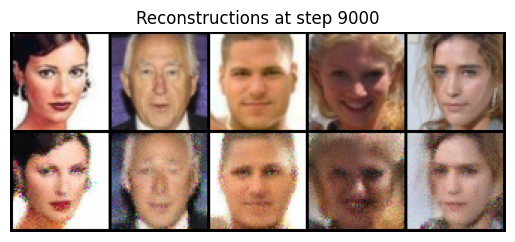

05:33:00 TRAINING Step [9100/24996]; Loss: 5.0665; Commitment: 1.0401; Usage (min/med/max/dead): 0.00, 1.22, 2.94, 30%
Checkpoint saved at step 9166 to /content/drive/MyDrive/vq_models/checkpoint.pt


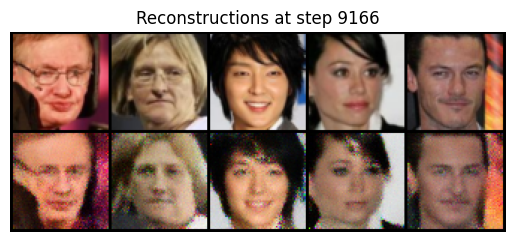

05:33:33 TRAINING Step [9200/24996]; Loss: 5.0735; Commitment: 1.0490; Usage (min/med/max/dead): 0.00, 1.22, 2.92, 30%
05:34:04 TRAINING Step [9300/24996]; Loss: 5.0693; Commitment: 1.0431; Usage (min/med/max/dead): 0.00, 1.21, 2.90, 30%
05:34:36 TRAINING Step [9400/24996]; Loss: 5.0759; Commitment: 1.0536; Usage (min/med/max/dead): 0.00, 1.22, 2.99, 30%
05:35:07 TRAINING Step [9500/24996]; Loss: 5.0695; Commitment: 1.0418; Usage (min/med/max/dead): 0.00, 1.23, 2.99, 30%
05:35:39 TRAINING Step [9600/24996]; Loss: 5.0733; Commitment: 1.0517; Usage (min/med/max/dead): 0.00, 1.22, 3.02, 30%
05:36:10 TRAINING Step [9700/24996]; Loss: 5.0720; Commitment: 1.0531; Usage (min/med/max/dead): 0.00, 1.22, 3.03, 30%
05:36:42 TRAINING Step [9800/24996]; Loss: 5.0798; Commitment: 1.0553; Usage (min/med/max/dead): 0.00, 1.23, 3.04, 30%
05:37:13 TRAINING Step [9900/24996]; Loss: 5.0755; Commitment: 1.0550; Usage (min/med/max/dead): 0.00, 1.23, 3.05, 30%
05:37:45 TRAINING Step [10000/24996]; Loss: 5.07

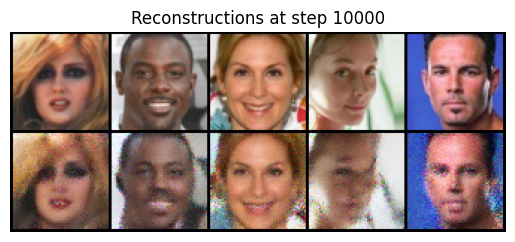

05:38:18 TRAINING Step [10100/24996]; Loss: 5.0775; Commitment: 1.0611; Usage (min/med/max/dead): 0.00, 1.23, 2.94, 30%
05:38:49 TRAINING Step [10200/24996]; Loss: 5.0799; Commitment: 1.0593; Usage (min/med/max/dead): 0.00, 1.23, 2.93, 30%
05:39:21 TRAINING Step [10300/24996]; Loss: 5.0807; Commitment: 1.0583; Usage (min/med/max/dead): 0.00, 1.23, 2.91, 30%
05:39:52 TRAINING Step [10400/24996]; Loss: 5.0752; Commitment: 1.0546; Usage (min/med/max/dead): 0.00, 1.22, 2.92, 30%
05:40:24 TRAINING Step [10500/24996]; Loss: 5.0765; Commitment: 1.0569; Usage (min/med/max/dead): 0.00, 1.21, 2.93, 30%
05:40:55 TRAINING Step [10600/24996]; Loss: 5.0760; Commitment: 1.0643; Usage (min/med/max/dead): 0.00, 1.22, 2.91, 30%
05:41:27 TRAINING Step [10700/24996]; Loss: 5.0827; Commitment: 1.0725; Usage (min/med/max/dead): 0.00, 1.23, 2.88, 30%
Checkpoint saved at step 10749 to /content/drive/MyDrive/vq_models/checkpoint.pt


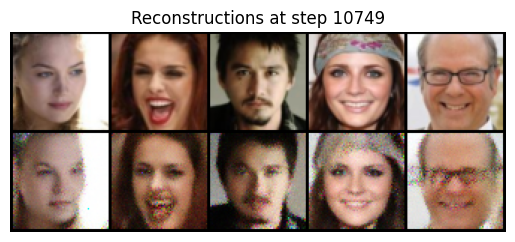

05:42:00 TRAINING Step [10800/24996]; Loss: 5.0779; Commitment: 1.0620; Usage (min/med/max/dead): 0.00, 1.22, 2.82, 30%
05:42:31 TRAINING Step [10900/24996]; Loss: 5.0837; Commitment: 1.0719; Usage (min/med/max/dead): 0.00, 1.23, 2.88, 30%
05:43:03 TRAINING Step [11000/24996]; Loss: 5.0788; Commitment: 1.0670; Usage (min/med/max/dead): 0.00, 1.23, 2.87, 30%
Checkpoint saved at step 11000 to /content/drive/MyDrive/vq_models/checkpoint.pt


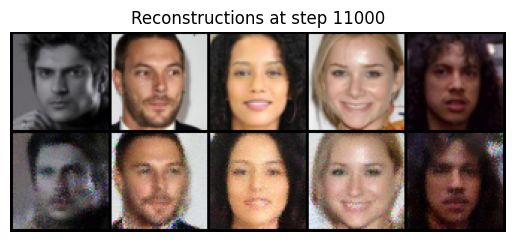

05:43:35 TRAINING Step [11100/24996]; Loss: 5.0805; Commitment: 1.0731; Usage (min/med/max/dead): 0.00, 1.22, 2.86, 30%
05:44:07 TRAINING Step [11200/24996]; Loss: 5.0795; Commitment: 1.0670; Usage (min/med/max/dead): 0.00, 1.22, 2.82, 30%
05:44:38 TRAINING Step [11300/24996]; Loss: 5.0868; Commitment: 1.0718; Usage (min/med/max/dead): 0.00, 1.22, 2.78, 30%
05:45:10 TRAINING Step [11400/24996]; Loss: 5.0807; Commitment: 1.0663; Usage (min/med/max/dead): 0.00, 1.22, 2.91, 30%
05:45:41 TRAINING Step [11500/24996]; Loss: 5.0836; Commitment: 1.0700; Usage (min/med/max/dead): 0.00, 1.23, 2.65, 30%
05:46:13 TRAINING Step [11600/24996]; Loss: 5.0784; Commitment: 1.0719; Usage (min/med/max/dead): 0.00, 1.24, 2.89, 30%
05:46:44 TRAINING Step [11700/24996]; Loss: 5.0833; Commitment: 1.0695; Usage (min/med/max/dead): 0.00, 1.23, 2.92, 30%
05:47:16 TRAINING Step [11800/24996]; Loss: 5.0840; Commitment: 1.0690; Usage (min/med/max/dead): 0.00, 1.23, 2.94, 30%
05:47:47 TRAINING Step [11900/24996]; Lo

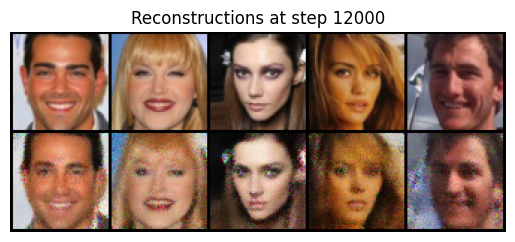

05:48:51 TRAINING Step [12100/24996]; Loss: 5.0870; Commitment: 1.0737; Usage (min/med/max/dead): 0.00, 1.24, 2.85, 30%
05:49:23 TRAINING Step [12200/24996]; Loss: 5.0853; Commitment: 1.0756; Usage (min/med/max/dead): 0.00, 1.24, 2.86, 30%
05:49:54 TRAINING Step [12300/24996]; Loss: 5.0851; Commitment: 1.0797; Usage (min/med/max/dead): 0.00, 1.24, 2.84, 30%
Checkpoint saved at step 12332 to /content/drive/MyDrive/vq_models/checkpoint.pt


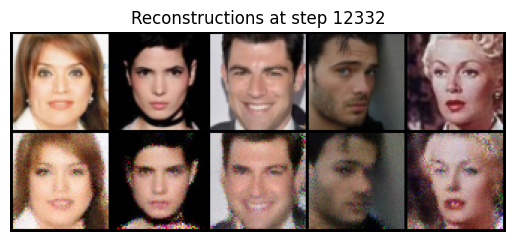

05:50:27 TRAINING Step [12400/24996]; Loss: 5.0890; Commitment: 1.0848; Usage (min/med/max/dead): 0.00, 1.24, 2.92, 30%
05:50:59 TRAINING Step [12500/24996]; Loss: 5.0912; Commitment: 1.0844; Usage (min/med/max/dead): 0.00, 1.24, 2.84, 30%
05:51:30 TRAINING Step [12600/24996]; Loss: 5.0883; Commitment: 1.0805; Usage (min/med/max/dead): 0.00, 1.24, 2.91, 30%
05:52:02 TRAINING Step [12700/24996]; Loss: 5.0869; Commitment: 1.0801; Usage (min/med/max/dead): 0.00, 1.23, 2.75, 30%
05:52:33 TRAINING Step [12800/24996]; Loss: 5.0820; Commitment: 1.0795; Usage (min/med/max/dead): 0.00, 1.23, 2.69, 30%
05:53:05 TRAINING Step [12900/24996]; Loss: 5.0906; Commitment: 1.0881; Usage (min/med/max/dead): 0.00, 1.24, 2.80, 30%
05:53:36 TRAINING Step [13000/24996]; Loss: 5.0895; Commitment: 1.0866; Usage (min/med/max/dead): 0.00, 1.24, 2.73, 30%
Checkpoint saved at step 13000 to /content/drive/MyDrive/vq_models/checkpoint.pt


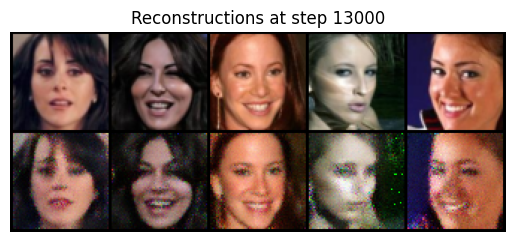

05:54:09 TRAINING Step [13100/24996]; Loss: 5.0893; Commitment: 1.0876; Usage (min/med/max/dead): 0.00, 1.23, 2.80, 30%
05:54:41 TRAINING Step [13200/24996]; Loss: 5.0869; Commitment: 1.0863; Usage (min/med/max/dead): 0.00, 1.23, 2.66, 30%
05:55:12 TRAINING Step [13300/24996]; Loss: 5.0888; Commitment: 1.0870; Usage (min/med/max/dead): 0.00, 1.23, 2.64, 30%
05:55:44 TRAINING Step [13400/24996]; Loss: 5.0894; Commitment: 1.0882; Usage (min/med/max/dead): 0.00, 1.24, 2.70, 30%
05:56:15 TRAINING Step [13500/24996]; Loss: 5.0923; Commitment: 1.0917; Usage (min/med/max/dead): 0.00, 1.24, 2.62, 30%
05:56:47 TRAINING Step [13600/24996]; Loss: 5.0911; Commitment: 1.0836; Usage (min/med/max/dead): 0.00, 1.24, 2.66, 30%
05:57:18 TRAINING Step [13700/24996]; Loss: 5.0851; Commitment: 1.0900; Usage (min/med/max/dead): 0.00, 1.23, 2.86, 30%
05:57:50 TRAINING Step [13800/24996]; Loss: 5.0934; Commitment: 1.0941; Usage (min/med/max/dead): 0.00, 1.24, 2.80, 30%
05:58:22 TRAINING Step [13900/24996]; Lo

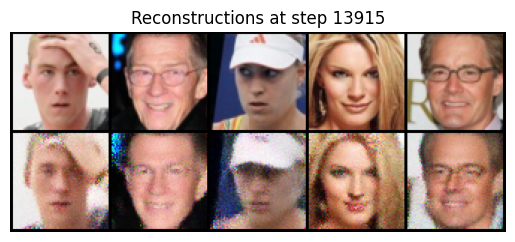

05:58:54 TRAINING Step [14000/24996]; Loss: 5.0905; Commitment: 1.0914; Usage (min/med/max/dead): 0.00, 1.25, 2.58, 30%
Checkpoint saved at step 14000 to /content/drive/MyDrive/vq_models/checkpoint.pt


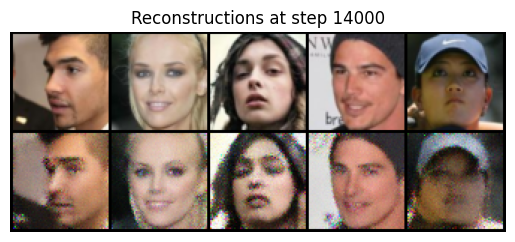

05:59:27 TRAINING Step [14100/24996]; Loss: 5.0882; Commitment: 1.0928; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
05:59:59 TRAINING Step [14200/24996]; Loss: 5.0949; Commitment: 1.0975; Usage (min/med/max/dead): 0.00, 1.24, 2.66, 30%
06:00:30 TRAINING Step [14300/24996]; Loss: 5.0916; Commitment: 1.0970; Usage (min/med/max/dead): 0.00, 1.24, 2.68, 30%
06:01:02 TRAINING Step [14400/24996]; Loss: 5.0941; Commitment: 1.1003; Usage (min/med/max/dead): 0.00, 1.24, 2.71, 30%
06:01:33 TRAINING Step [14500/24996]; Loss: 5.0965; Commitment: 1.0991; Usage (min/med/max/dead): 0.00, 1.25, 2.83, 30%
06:02:05 TRAINING Step [14600/24996]; Loss: 5.0966; Commitment: 1.1020; Usage (min/med/max/dead): 0.00, 1.24, 2.80, 30%
06:02:36 TRAINING Step [14700/24996]; Loss: 5.0973; Commitment: 1.0996; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:03:08 TRAINING Step [14800/24996]; Loss: 5.0975; Commitment: 1.0947; Usage (min/med/max/dead): 0.00, 1.24, 2.65, 30%
06:03:40 TRAINING Step [14900/24996]; Lo

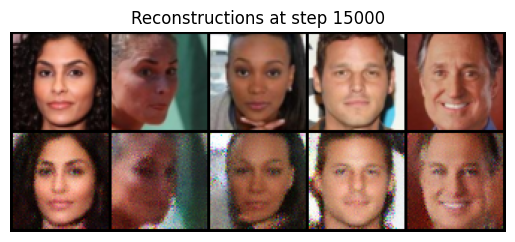

06:04:44 TRAINING Step [15100/24996]; Loss: 5.0954; Commitment: 1.1039; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
06:05:16 TRAINING Step [15200/24996]; Loss: 5.0947; Commitment: 1.1008; Usage (min/med/max/dead): 0.00, 1.24, 2.63, 30%
06:05:47 TRAINING Step [15300/24996]; Loss: 5.0978; Commitment: 1.1033; Usage (min/med/max/dead): 0.00, 1.24, 2.62, 30%
06:06:19 TRAINING Step [15400/24996]; Loss: 5.1022; Commitment: 1.1068; Usage (min/med/max/dead): 0.00, 1.25, 2.60, 30%
Checkpoint saved at step 15498 to /content/drive/MyDrive/vq_models/checkpoint.pt


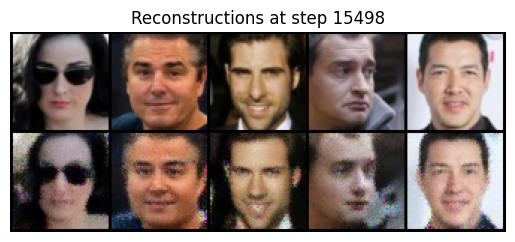

06:06:52 TRAINING Step [15500/24996]; Loss: 5.0997; Commitment: 1.1069; Usage (min/med/max/dead): 0.00, 1.26, 2.70, 30%
06:07:23 TRAINING Step [15600/24996]; Loss: 5.1020; Commitment: 1.1110; Usage (min/med/max/dead): 0.00, 1.26, 2.71, 30%
06:07:55 TRAINING Step [15700/24996]; Loss: 5.1008; Commitment: 1.1051; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
06:08:26 TRAINING Step [15800/24996]; Loss: 5.0996; Commitment: 1.1110; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:08:58 TRAINING Step [15900/24996]; Loss: 5.1030; Commitment: 1.1103; Usage (min/med/max/dead): 0.00, 1.25, 2.62, 30%
06:09:29 TRAINING Step [16000/24996]; Loss: 5.1017; Commitment: 1.1111; Usage (min/med/max/dead): 0.00, 1.25, 2.64, 30%
Checkpoint saved at step 16000 to /content/drive/MyDrive/vq_models/checkpoint.pt


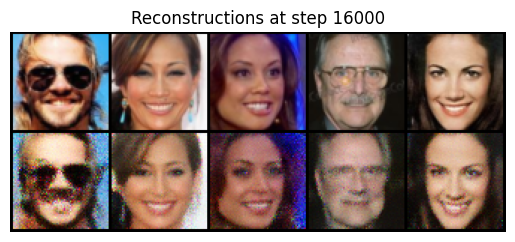

06:10:02 TRAINING Step [16100/24996]; Loss: 5.1047; Commitment: 1.1155; Usage (min/med/max/dead): 0.00, 1.25, 2.64, 30%
06:10:34 TRAINING Step [16200/24996]; Loss: 5.1047; Commitment: 1.1147; Usage (min/med/max/dead): 0.00, 1.26, 2.66, 30%
06:11:05 TRAINING Step [16300/24996]; Loss: 5.1044; Commitment: 1.1150; Usage (min/med/max/dead): 0.00, 1.25, 2.66, 30%
06:11:37 TRAINING Step [16400/24996]; Loss: 5.1037; Commitment: 1.1135; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:12:08 TRAINING Step [16500/24996]; Loss: 5.1062; Commitment: 1.1154; Usage (min/med/max/dead): 0.00, 1.25, 2.60, 30%
06:12:40 TRAINING Step [16600/24996]; Loss: 5.1050; Commitment: 1.1148; Usage (min/med/max/dead): 0.00, 1.25, 2.56, 30%
06:13:11 TRAINING Step [16700/24996]; Loss: 5.1026; Commitment: 1.1167; Usage (min/med/max/dead): 0.00, 1.25, 2.66, 30%
06:13:43 TRAINING Step [16800/24996]; Loss: 5.1053; Commitment: 1.1188; Usage (min/med/max/dead): 0.00, 1.25, 2.61, 30%
06:14:15 TRAINING Step [16900/24996]; Lo

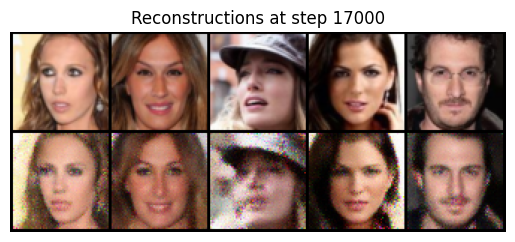

Checkpoint saved at step 17081 to /content/drive/MyDrive/vq_models/checkpoint.pt


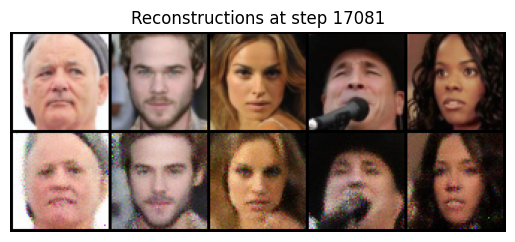

06:15:20 TRAINING Step [17100/24996]; Loss: 5.1035; Commitment: 1.1194; Usage (min/med/max/dead): 0.00, 1.26, 2.74, 30%
06:15:52 TRAINING Step [17200/24996]; Loss: 5.1063; Commitment: 1.1217; Usage (min/med/max/dead): 0.00, 1.25, 2.64, 30%
06:16:23 TRAINING Step [17300/24996]; Loss: 5.1106; Commitment: 1.1245; Usage (min/med/max/dead): 0.00, 1.25, 2.74, 30%
06:16:55 TRAINING Step [17400/24996]; Loss: 5.1095; Commitment: 1.1241; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:17:26 TRAINING Step [17500/24996]; Loss: 5.1095; Commitment: 1.1206; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:17:58 TRAINING Step [17600/24996]; Loss: 5.1042; Commitment: 1.1194; Usage (min/med/max/dead): 0.00, 1.25, 2.56, 30%
06:18:29 TRAINING Step [17700/24996]; Loss: 5.1104; Commitment: 1.1240; Usage (min/med/max/dead): 0.00, 1.26, 2.57, 30%
06:19:01 TRAINING Step [17800/24996]; Loss: 5.1083; Commitment: 1.1233; Usage (min/med/max/dead): 0.00, 1.27, 2.57, 30%
06:19:32 TRAINING Step [17900/24996]; Lo

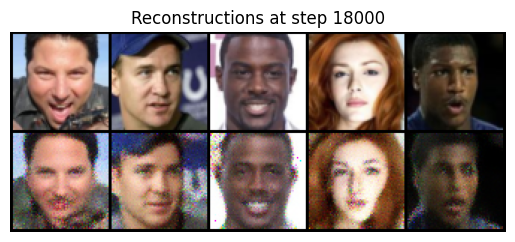

06:20:36 TRAINING Step [18100/24996]; Loss: 5.1113; Commitment: 1.1265; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:21:08 TRAINING Step [18200/24996]; Loss: 5.1173; Commitment: 1.1284; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:21:40 TRAINING Step [18300/24996]; Loss: 5.1141; Commitment: 1.1315; Usage (min/med/max/dead): 0.00, 1.25, 2.72, 30%
06:22:11 TRAINING Step [18400/24996]; Loss: 5.1124; Commitment: 1.1298; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:22:43 TRAINING Step [18500/24996]; Loss: 5.1198; Commitment: 1.1303; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:23:14 TRAINING Step [18600/24996]; Loss: 5.1231; Commitment: 1.1346; Usage (min/med/max/dead): 0.00, 1.25, 2.60, 30%
Checkpoint saved at step 18664 to /content/drive/MyDrive/vq_models/checkpoint.pt


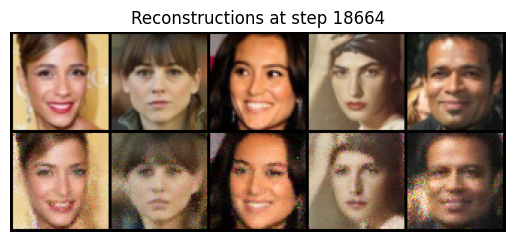

06:23:47 TRAINING Step [18700/24996]; Loss: 5.1115; Commitment: 1.1279; Usage (min/med/max/dead): 0.00, 1.25, 2.62, 30%
06:24:19 TRAINING Step [18800/24996]; Loss: 5.1142; Commitment: 1.1305; Usage (min/med/max/dead): 0.00, 1.25, 2.70, 30%
06:24:50 TRAINING Step [18900/24996]; Loss: 5.1148; Commitment: 1.1331; Usage (min/med/max/dead): 0.00, 1.25, 2.73, 30%
06:25:22 TRAINING Step [19000/24996]; Loss: 5.1177; Commitment: 1.1334; Usage (min/med/max/dead): 0.00, 1.25, 2.62, 30%
Checkpoint saved at step 19000 to /content/drive/MyDrive/vq_models/checkpoint.pt


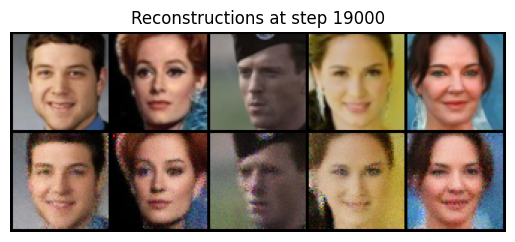

06:25:54 TRAINING Step [19100/24996]; Loss: 5.1237; Commitment: 1.1340; Usage (min/med/max/dead): 0.00, 1.25, 2.70, 30%
06:26:26 TRAINING Step [19200/24996]; Loss: 5.1153; Commitment: 1.1301; Usage (min/med/max/dead): 0.00, 1.25, 2.74, 30%
06:26:57 TRAINING Step [19300/24996]; Loss: 5.1204; Commitment: 1.1326; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:27:29 TRAINING Step [19400/24996]; Loss: 5.1147; Commitment: 1.1359; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:28:00 TRAINING Step [19500/24996]; Loss: 5.1192; Commitment: 1.1380; Usage (min/med/max/dead): 0.00, 1.24, 2.59, 30%
06:28:32 TRAINING Step [19600/24996]; Loss: 5.1154; Commitment: 1.1352; Usage (min/med/max/dead): 0.00, 1.25, 2.61, 30%
06:29:03 TRAINING Step [19700/24996]; Loss: 5.1212; Commitment: 1.1408; Usage (min/med/max/dead): 0.00, 1.25, 2.63, 30%
06:29:35 TRAINING Step [19800/24996]; Loss: 5.1175; Commitment: 1.1374; Usage (min/med/max/dead): 0.00, 1.24, 2.66, 30%
06:30:06 TRAINING Step [19900/24996]; Lo

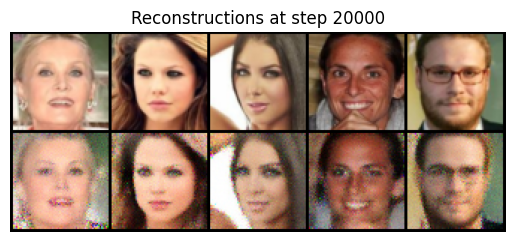

06:31:10 TRAINING Step [20100/24996]; Loss: 5.1158; Commitment: 1.1375; Usage (min/med/max/dead): 0.00, 1.25, 2.59, 30%
06:31:42 TRAINING Step [20200/24996]; Loss: 5.1274; Commitment: 1.1433; Usage (min/med/max/dead): 0.00, 1.26, 2.68, 30%
Checkpoint saved at step 20247 to /content/drive/MyDrive/vq_models/checkpoint.pt


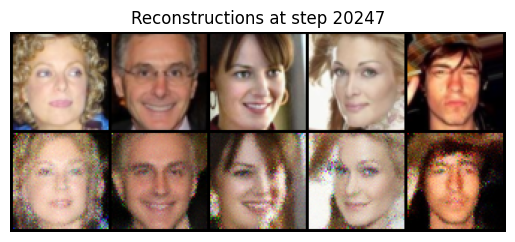

06:32:15 TRAINING Step [20300/24996]; Loss: 5.1200; Commitment: 1.1406; Usage (min/med/max/dead): 0.00, 1.25, 2.64, 30%
06:32:46 TRAINING Step [20400/24996]; Loss: 5.1219; Commitment: 1.1399; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:33:18 TRAINING Step [20500/24996]; Loss: 5.1284; Commitment: 1.1477; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:33:49 TRAINING Step [20600/24996]; Loss: 5.1309; Commitment: 1.1480; Usage (min/med/max/dead): 0.00, 1.24, 2.62, 30%
06:34:21 TRAINING Step [20700/24996]; Loss: 5.1270; Commitment: 1.1474; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
06:34:53 TRAINING Step [20800/24996]; Loss: 5.1234; Commitment: 1.1447; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
06:35:24 TRAINING Step [20900/24996]; Loss: 5.1332; Commitment: 1.1513; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:35:56 TRAINING Step [21000/24996]; Loss: 5.1311; Commitment: 1.1506; Usage (min/med/max/dead): 0.00, 1.25, 2.63, 30%
Checkpoint saved at step 21000 to /conte

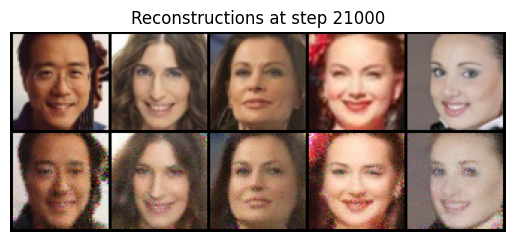

06:36:29 TRAINING Step [21100/24996]; Loss: 5.1202; Commitment: 1.1457; Usage (min/med/max/dead): 0.00, 1.25, 2.72, 30%
06:37:00 TRAINING Step [21200/24996]; Loss: 5.1273; Commitment: 1.1441; Usage (min/med/max/dead): 0.00, 1.26, 2.66, 30%
06:37:32 TRAINING Step [21300/24996]; Loss: 5.1373; Commitment: 1.1564; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:38:03 TRAINING Step [21400/24996]; Loss: 5.1295; Commitment: 1.1533; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:38:35 TRAINING Step [21500/24996]; Loss: 5.1332; Commitment: 1.1547; Usage (min/med/max/dead): 0.00, 1.25, 2.57, 30%
06:39:06 TRAINING Step [21600/24996]; Loss: 5.1347; Commitment: 1.1555; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:39:38 TRAINING Step [21700/24996]; Loss: 5.1371; Commitment: 1.1558; Usage (min/med/max/dead): 0.00, 1.25, 2.62, 30%
06:40:10 TRAINING Step [21800/24996]; Loss: 5.1389; Commitment: 1.1587; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
Checkpoint saved at step 21830 to /conte

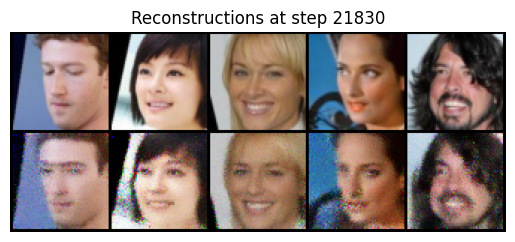

06:40:43 TRAINING Step [21900/24996]; Loss: 5.1356; Commitment: 1.1552; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:41:14 TRAINING Step [22000/24996]; Loss: 5.1431; Commitment: 1.1619; Usage (min/med/max/dead): 0.00, 1.25, 2.63, 30%
Checkpoint saved at step 22000 to /content/drive/MyDrive/vq_models/checkpoint.pt


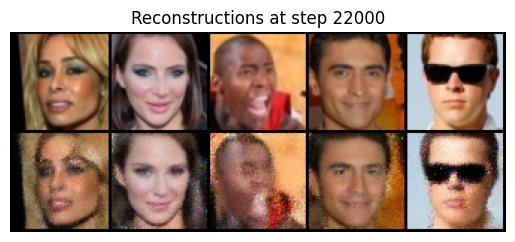

06:41:47 TRAINING Step [22100/24996]; Loss: 5.1358; Commitment: 1.1573; Usage (min/med/max/dead): 0.00, 1.25, 2.62, 30%
06:42:19 TRAINING Step [22200/24996]; Loss: 5.1422; Commitment: 1.1642; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:42:50 TRAINING Step [22300/24996]; Loss: 5.1425; Commitment: 1.1615; Usage (min/med/max/dead): 0.00, 1.26, 2.62, 30%
06:43:22 TRAINING Step [22400/24996]; Loss: 5.1386; Commitment: 1.1611; Usage (min/med/max/dead): 0.00, 1.25, 2.63, 30%
06:43:53 TRAINING Step [22500/24996]; Loss: 5.1381; Commitment: 1.1628; Usage (min/med/max/dead): 0.00, 1.26, 2.74, 30%
06:44:25 TRAINING Step [22600/24996]; Loss: 5.1450; Commitment: 1.1672; Usage (min/med/max/dead): 0.00, 1.26, 2.65, 30%
06:44:57 TRAINING Step [22700/24996]; Loss: 5.1563; Commitment: 1.1733; Usage (min/med/max/dead): 0.00, 1.26, 2.66, 30%
06:45:28 TRAINING Step [22800/24996]; Loss: 5.1508; Commitment: 1.1725; Usage (min/med/max/dead): 0.00, 1.25, 2.60, 30%
06:46:00 TRAINING Step [22900/24996]; Lo

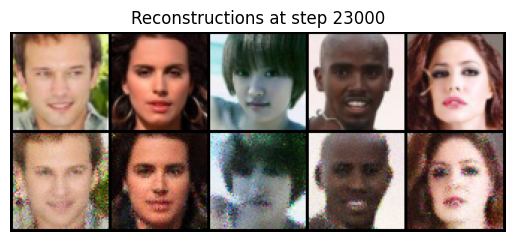

06:47:04 TRAINING Step [23100/24996]; Loss: 5.1501; Commitment: 1.1734; Usage (min/med/max/dead): 0.00, 1.26, 2.57, 30%
06:47:35 TRAINING Step [23200/24996]; Loss: 5.1592; Commitment: 1.1795; Usage (min/med/max/dead): 0.00, 1.25, 2.70, 30%
06:48:07 TRAINING Step [23300/24996]; Loss: 5.1548; Commitment: 1.1719; Usage (min/med/max/dead): 0.00, 1.25, 2.64, 30%
06:48:39 TRAINING Step [23400/24996]; Loss: 5.1514; Commitment: 1.1710; Usage (min/med/max/dead): 0.00, 1.26, 2.69, 30%
Checkpoint saved at step 23413 to /content/drive/MyDrive/vq_models/checkpoint.pt


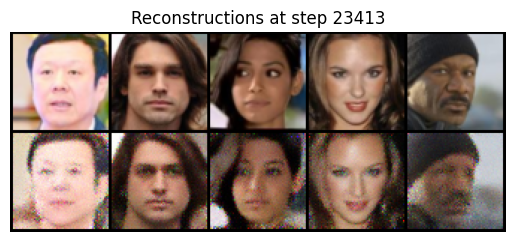

06:49:12 TRAINING Step [23500/24996]; Loss: 5.1657; Commitment: 1.1844; Usage (min/med/max/dead): 0.00, 1.26, 2.62, 30%
06:49:43 TRAINING Step [23600/24996]; Loss: 5.1579; Commitment: 1.1794; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:50:15 TRAINING Step [23700/24996]; Loss: 5.1588; Commitment: 1.1838; Usage (min/med/max/dead): 0.00, 1.25, 2.67, 30%
06:50:46 TRAINING Step [23800/24996]; Loss: 5.1636; Commitment: 1.1840; Usage (min/med/max/dead): 0.00, 1.26, 2.57, 30%
06:51:18 TRAINING Step [23900/24996]; Loss: 5.1602; Commitment: 1.1814; Usage (min/med/max/dead): 0.00, 1.25, 2.57, 30%
06:51:49 TRAINING Step [24000/24996]; Loss: 5.1593; Commitment: 1.1821; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
Checkpoint saved at step 24000 to /content/drive/MyDrive/vq_models/checkpoint.pt


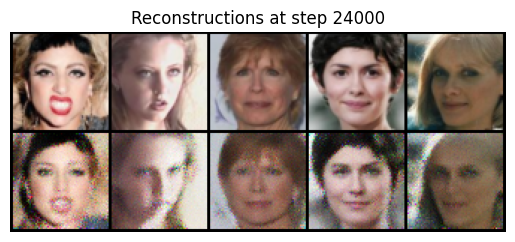

06:52:22 TRAINING Step [24100/24996]; Loss: 5.1673; Commitment: 1.1885; Usage (min/med/max/dead): 0.00, 1.25, 2.65, 30%
06:52:53 TRAINING Step [24200/24996]; Loss: 5.1621; Commitment: 1.1820; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:53:25 TRAINING Step [24300/24996]; Loss: 5.1657; Commitment: 1.1863; Usage (min/med/max/dead): 0.00, 1.25, 2.69, 30%
06:53:56 TRAINING Step [24400/24996]; Loss: 5.1655; Commitment: 1.1871; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:54:28 TRAINING Step [24500/24996]; Loss: 5.1670; Commitment: 1.1881; Usage (min/med/max/dead): 0.00, 1.25, 2.66, 30%
06:54:59 TRAINING Step [24600/24996]; Loss: 5.1740; Commitment: 1.1945; Usage (min/med/max/dead): 0.00, 1.25, 2.68, 30%
06:55:31 TRAINING Step [24700/24996]; Loss: 5.1766; Commitment: 1.1923; Usage (min/med/max/dead): 0.00, 1.26, 2.66, 30%
06:56:03 TRAINING Step [24800/24996]; Loss: 5.1742; Commitment: 1.1930; Usage (min/med/max/dead): 0.00, 1.26, 2.61, 30%
06:56:34 TRAINING Step [24900/24996]; Lo

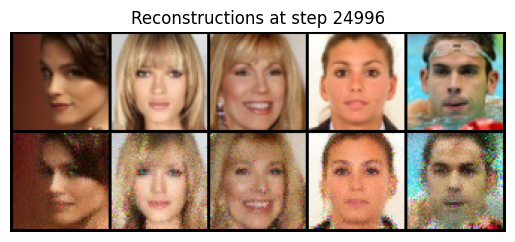

Training complete.


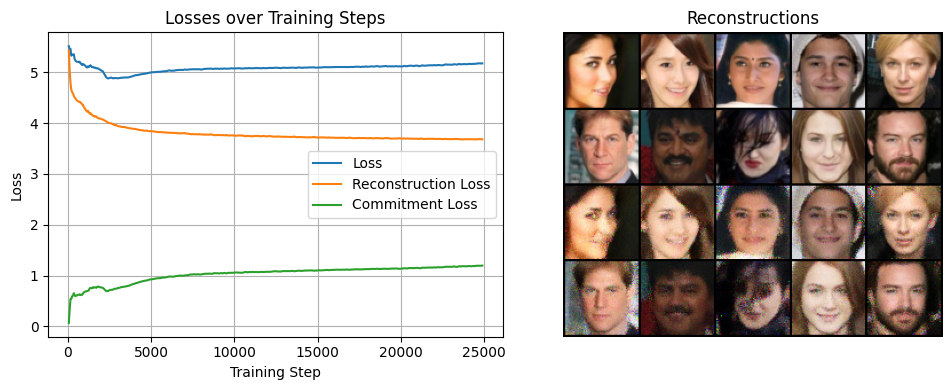

In [ ]:
from time import strftime

# Initialize and train a model. If you just want to load one from a checkpoint and not train, set EPOCHS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training hyperparemeters
EPOCHS = 12
BATCH_SIZE = 256
BETA = 0.25
GRAD_CLIP = None

# logging/saving hyperparemters
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
CHECKPOINT_DIR = '/content/drive/MyDrive/vq_models'
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'checkpoint.pt')
LOAD_FROM_CHECKPOINT = True

dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
model = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

training_losses = []
training_steps = 0
running_losses = [0.0, 0.0, 0.0]

# load from checkpoint
if LOAD_FROM_CHECKPOINT:
    if not os.path.exists(CHECKPOINT_PATH):
        print(f'WARNING: Checkpoint not found at {CHECKPOINT_PATH}!')
    else:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        training_steps = checkpoint['training_steps']
        training_losses = checkpoint['training_losses']
        running_losses = checkpoint['running_losses']

        print(f'Checkpoint loaded. Resuming from training step {training_steps}.')

total_steps = training_steps + len(dataloader) * EPOCHS

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        input, target = batch
        input = input.to(device)
        target = target.to(device)

        reconstruction_loss, commitment_loss, codebook_loss = model(input, target)
        if model.use_EMA:
            loss = reconstruction_loss + BETA * commitment_loss + codebook_loss
        else:
            loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
        optimizer.step()
        training_steps += 1

        running_losses[0] += loss.item()
        running_losses[1] += reconstruction_loss.item()
        running_losses[2] += commitment_loss.item()

        # logging step
        if training_steps % LOG_INTERVAL == 0:
            avg_losses = [loss / LOG_INTERVAL for loss in running_losses]
            running_losses = [0.0, 0.0, 0.0]
            training_losses.append((training_steps, avg_losses))
            with torch.no_grad():
                p = model.quantizer.N / model.quantizer.N.sum() * 512
                print(f'{strftime('%H:%M:%S')} TRAINING Step [{training_steps}/{total_steps}]; Loss: {avg_losses[0]:.4f}; Commitment: {avg_losses[2]:.4f}; Usage (min/med/max/dead): {p.min().item():.2f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.01) / 512 * 100:.0f}%')

        # saving step
        if training_steps % SAVE_INTERVAL == 0 or batch_idx == len(dataloader) - 1:
            checkpoint = {
                'training_steps': training_steps,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'training_losses': training_losses,
                'running_losses': running_losses,
            }

            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f'Checkpoint saved at step {training_steps} to {CHECKPOINT_PATH}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2

            input, target = next(iter(dataloader))
            input = input[:grid_x * grid_y // 2].to(device)
            target = target[:grid_x * grid_y // 2].to(device)

            model.eval()
            params = model.reconstruct(input)
            reconstructed = model.decoder.sample_from_params(params)
            model.train()

            images = torch.cat((target, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

            plt.title(f'Reconstructions at step {training_steps}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

# Prepare loss data
steps_list = [item[0] for item in training_losses]
avg_losses_list = [item[1] for item in training_losses]

steps = np.array(steps_list)
losses = np.array(avg_losses_list)   # shape: (num_steps, 3)

# Prepare reconstructions
grid_x = 5
grid_y = 4

input, target = next(iter(dataloader))
input = input[:grid_x * grid_y // 2].to(device)
target = target[:grid_x * grid_y // 2].to(device)

model.eval()
params = model.reconstruct(input)
reconstructed = model.decoder.sample_from_params(params)
model.train()

images = torch.cat((target, reconstructed), dim=0)
img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(steps, losses[:, 0], label='Loss')
axes[0].plot(steps, losses[:, 1], label='Reconstruction Loss')
axes[0].plot(steps, losses[:, 2], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [ ]:
from tqdm import tqdm

celeba_indices = []

model.eval()
for batch in tqdm(dataloader):
    input, target = batch
    input = input.to(device)
    indices = model.compute_indices(input)
    celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
print('Shape:', celeba_indices.shape)
celeba_indices = celeba_indices.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, os.path.join(CHECKPOINT_DIR, "celeba_vq_indices_uint16.pt"))

100%|██████████| 1583/1583 [01:33<00:00, 16.96it/s]


Concatenating...
Shape: torch.Size([405198, 64])
Saving...


### Random Image Generation with Uniform Prior

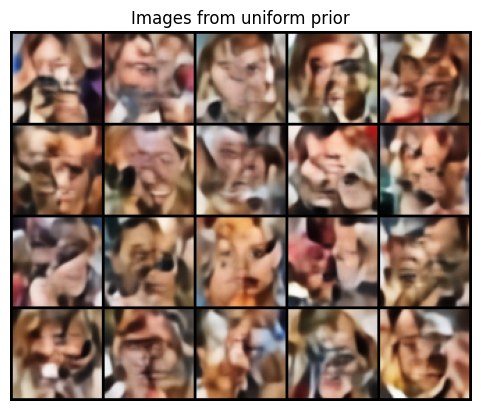

In [ ]:
# visualize
grid_x = 5
grid_y = 4

model.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    embeddings = model.quantizer.get_latent_tensor_from_indices(samples)
    logits = model.decoder(embeddings)
    reconstructed = model.decoder.sample_from_logits(logits)

img = torchvision.utils.make_grid(reconstructed.float() / 255.0, grid_x)
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())